In [1]:
#! /usr/bin/env python3

import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr, spearmanr
from scipy.stats import false_discovery_control

# input
df = pd.read_csv("dummy_zscore2.txt", sep=r"\s+", index_col=0)
print(df)
# print(df.shape)        # should be (5, 6)
# print(df.index)        # should be ['gene1', 'gene2', ...]
# print(df.columns)      # should be ['s1NM', 's2NM', ...]
# print(df.dtypes)       # should all be float

# Split columns by substring
nm_cols = [c for c in df.columns if "NM" in c]
ds_cols = [c for c in df.columns if "DS" in c]

# Create two separate DataFrames
df_nm = df[nm_cols]
df_ds = df[ds_cols]

print("NM subset:\n", df_nm.head(), "\n")
print("DS subset:\n", df_ds.head(), "\n")


        s1NM   s2NM  s3NM   s4NM   s5NM   s6NM   s7DS   s8DS   s9DS  s10DS  \
g_IDs                                                                        
gene1  0.000  0.000  0.00  0.000  0.000  0.000  0.002  0.001  0.000  0.000   
gene2  0.025  0.040  0.02  0.029  0.030  0.025  0.100  0.125  0.146  0.113   
gene3  1.000  1.000  0.25  1.000  1.000  0.906  0.000  0.000  0.003  0.001   
gene4  0.020  0.033  0.05  0.032  0.043  0.031  1.000  1.000  1.000  1.000   
gene5  0.500  0.833  1.00  0.799  1.000  1.000  0.009  0.005  0.007  0.008   

       s11DS  s12DS  
g_IDs                
gene1  0.000  0.000  
gene2  0.106  0.121  
gene3  0.001  0.001  
gene4  1.000  1.000  
gene5  0.004  0.003  
NM subset:
         s1NM   s2NM  s3NM   s4NM   s5NM   s6NM
g_IDs                                         
gene1  0.000  0.000  0.00  0.000  0.000  0.000
gene2  0.025  0.040  0.02  0.029  0.030  0.025
gene3  1.000  1.000  0.25  1.000  1.000  0.906
gene4  0.020  0.033  0.05  0.032  0.043  0.031
gene5

In [2]:
expression_df = df_ds # using only NM samples for correlation
name = "DS"
expression_df = expression_df.loc[expression_df.var(axis=1) > 1e-6] # check the variance calculation logic

In [3]:
# gene-gene correlation matrix
genes = expression_df.index
#print(genes)
n_genes = len(genes)

pearson_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
pearson_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

spearman_corr = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)
spearman_pval = pd.DataFrame(np.zeros((n_genes, n_genes)), index=genes, columns=genes)

# pairwise correlations and p-values
for i, g1 in enumerate(genes):
    for j, g2 in enumerate(genes):
        if j >= i:
            r, p = pearsonr(expression_df.loc[g1], expression_df.loc[g2])
            pearson_corr.loc[g1, g2] = pearson_corr.loc[g2, g1] = r
            pearson_pval.loc[g1, g2] = pearson_pval.loc[g2, g1] = p

            r_s, p_s = spearmanr(expression_df.loc[g1], expression_df.loc[g2])
            spearman_corr.loc[g1, g2] = spearman_corr.loc[g2, g1] = r_s
            spearman_pval.loc[g1, g2] = spearman_pval.loc[g2, g1] = p_s


# FDR (Benjamini-Hochberg) 
# explain why FDR correction is needed
pearson_fdr = pd.DataFrame(
    false_discovery_control(pearson_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

spearman_fdr = pd.DataFrame(
    false_discovery_control(spearman_pval.values.flatten(), method='bh').reshape(n_genes, n_genes),
    index=genes, columns=genes
)

print("Pearson Correlation Matrix:")
print(pearson_corr)
print("Pearson FDR Matrix:")
print(pearson_fdr)
print("Spearman Correlation Matrix:")
print(spearman_corr)
print("Spearman FDR Matrix:")
print(spearman_fdr) 

Pearson Correlation Matrix:
g_IDs     gene2         gene3         gene5
g_IDs                                      
gene2  1.000000  7.490360e-01 -1.449047e-01
gene3  0.749036  1.000000e+00  2.775558e-17
gene5 -0.144905  2.775558e-17  1.000000e+00
Pearson FDR Matrix:
g_IDs     gene2     gene3  gene5
g_IDs                           
gene2  0.000000  0.155828    1.0
gene3  0.155828  0.000000    1.0
gene5  1.000000  1.000000    0.0
Spearman Correlation Matrix:
g_IDs     gene2     gene3     gene5
g_IDs                              
gene2  1.000000  0.462910 -0.314286
gene3  0.462910  1.000000 -0.246885
gene5 -0.314286 -0.246885  1.000000
Spearman FDR Matrix:
g_IDs     gene2     gene3     gene5
g_IDs                              
gene2  0.000000  0.637196  0.637196
gene3  0.637196  0.000000  0.637196
gene5  0.637196  0.637196  0.000000


In [4]:
# Define FDR significance threshold
fdr_threshold = 0.05

# Count significant gene–gene pairs (excluding self-pairs)
pearson_sig = np.sum((pearson_fdr < fdr_threshold).values) - len(genes)
spearman_sig = np.sum((spearman_fdr < fdr_threshold).values) - len(genes)

print(f"Significant Pearson pairs (FDR<{fdr_threshold}): {pearson_sig}")
print(f"Significant Spearman pairs (FDR<{fdr_threshold}): {spearman_sig}")

# Compare counts
# highlight pearson vs spearman choosen method
if pearson_sig > spearman_sig:
    chosen_method = "pearson"
elif spearman_sig > pearson_sig:
    chosen_method = "spearman"
else:
    # Tie → compare average |r²|
    pearson_r2 = np.nanmean(np.square(pearson_corr.values))
    spearman_r2 = np.nanmean(np.square(spearman_corr.values))
    chosen_method = "pearson" if pearson_r2 > spearman_r2 else "spearman"

print(f"Chosen method: {chosen_method.upper()}")

if chosen_method == "pearson":
    pearson_corr.to_csv(f"pearson_gene_correlation_r2_{name}.csv")
    pearson_fdr.to_csv(f"pearson_gene_correlation_fdr_{name}.csv")
else:
    spearman_corr.to_csv(f"spearman_gene_correlation_r2_{name}.csv")
    spearman_fdr.to_csv(f"spearman_gene_correlation_fdr_{name}.csv")


Significant Pearson pairs (FDR<0.05): 0
Significant Spearman pairs (FDR<0.05): 0
Chosen method: PEARSON


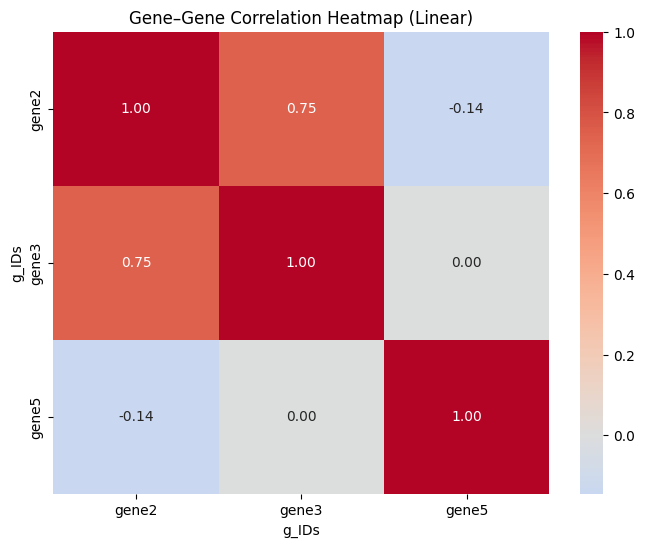

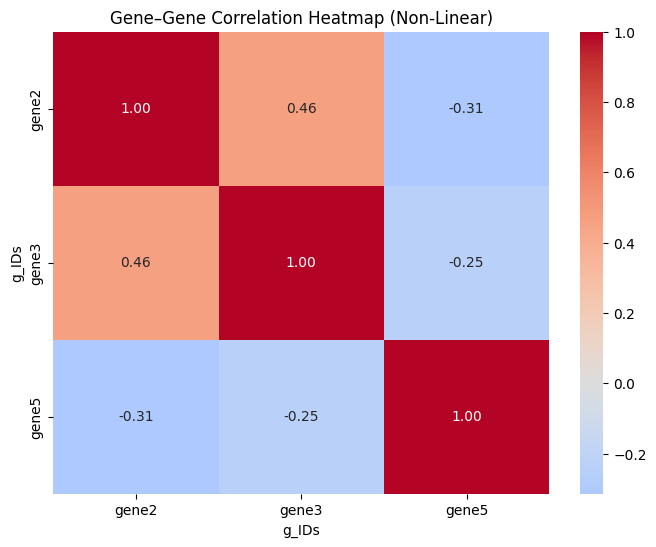

In [5]:
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Gene–Gene Correlation Heatmap (Linear)")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Gene–Gene Correlation Heatmap (Non-Linear)")
plt.show()

